In [1]:
!ls ../input

bcnn-model  bcnn-model-finetuned  stanford-dogs-dataset


In [2]:
!nvidia-smi

Sun Dec  8 13:42:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Importing Required Libraries

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split, sampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, models
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import xml.etree.ElementTree as ET

In [4]:
import torch
import torchvision
from tqdm import tqdm

In [5]:
## Checks for the availability of GPU 
if torch.cuda.is_available():
    print("working on gpu!")
    device = 'cuda'
else:
    print("No gpu! only cpu ;)")
    device = 'cpu'
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

if device == 'cpu':    
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
elif device == 'cuda':
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '0'

###############################################################################

working on gpu!


In [6]:
def crop_image(breed, dog, data_dir):
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

(300, 164, 3)
(295, 283, 3)
(260, 225, 3)
(354, 389, 3)


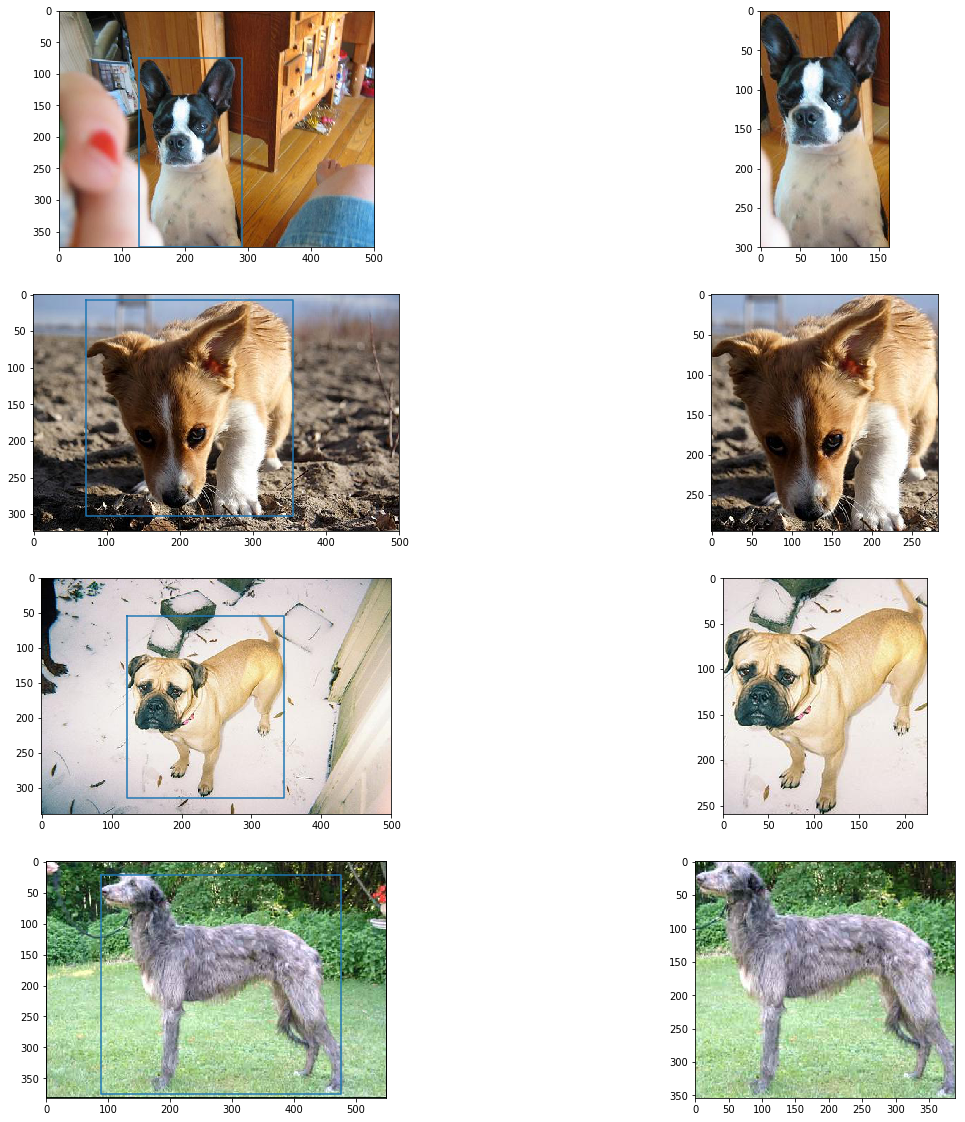

In [7]:
data_dir = '../input/stanford-dogs-dataset/'
breed_list = os.listdir(data_dir + 'images/Images/')

plt.figure(figsize=(20, 20))

for i in range(4):
    
    plt.subplot(421 + (i*2))
    
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(data_dir + 'annotations/Annotation/' + breed))
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    plt.imshow(img)
    
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    
    crop_img = crop_image(breed, dog, data_dir)
    print(crop_img.shape)
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

In [8]:
if 'cropped_data' not in os.listdir():
    
    os.mkdir('cropped_data')
    
    for breed in breed_list:
        os.mkdir('cropped_data/' + breed)
    
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('cropped_data'))))

Created 120 folders to store cropped images of the different breeds.


In [10]:
for breed in tqdm(os.listdir('cropped_data')):
    
    for file in os.listdir(data_dir + 'annotations/Annotation/' + breed):
        
        img = Image.open(data_dir + 'images/Images/' + breed + '/' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('cropped_data/' + breed + '/' + file + '.jpg')

100%|██████████| 120/120 [05:50<00:00,  2.92s/it]


In [11]:
img_count = 0

for folder in os.listdir('cropped_data'):
    
    for _ in os.listdir('cropped_data/' + folder):    
        img_count += 1
    
print('No. of Images: {}'.format(img_count))

No. of Images: 20580


In [12]:
!ls /kaggle/input

bcnn-model  bcnn-model-finetuned  stanford-dogs-dataset


In [13]:
# Data Augmentation
batch_size = 128
image_size = 299

image_transforms = {
    
    'train':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
    ]),
    'val':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.CenterCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
}

In [14]:
all_data = datasets.ImageFolder(root='cropped_data')

In [15]:
all_data.classes

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [16]:
train_data_len = int(len(all_data) * 0.8)
valid_data_len = int((len(all_data) - train_data_len) / 2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['val']

print(len(train_data), len(val_data), len(test_data))

16464 2058 2058


In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Define Model BCNN
**We will use DenseNet as the base architecture as suggested in the paper**

![title](http://vis-www.cs.umass.edu/bcnn/docs/teaser-bcnn.png)

In [18]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 299, 299]) torch.Size([128])


In [19]:
from torch import FloatTensor

def new_parameter(*size):
    out = nn.Parameter(FloatTensor(*size), requires_grad=True)
    torch.nn.init.xavier_normal_(out)
    return out


class Attention(nn.Module):
    
    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention = new_parameter(attention_size, 1)

    def forward(self, x_in):
        # after this, we have (bs, feature_size, feature_size) with a diff weight per each cell
        attention_score = torch.matmul(x_in, self.attention).squeeze()
        attention_score = F.softmax(attention_score).view(x_in.size(0), x_in.size(1), 1)
        scored_x = x_in * attention_score

        # now, sum across dim 1 to get the expected feature vector
        condensed_x = torch.sum(scored_x, dim=1)

        return condensed_x

In [20]:
features = 1024
fmap_size = 9

class BCNN_DNet_Attention(nn.Module):
    def __init__(self, fine_tune=False):
        super(BCNN_DNet_Attention, self).__init__()
        
        base_net = models.densenet121(pretrained=True)
        
        # freezing parameters
        if not fine_tune:
            for param in base_net.parameters():
                param.requires_grad = False
        else:
            
            for param in base_net.parameters():
                param.requires_grad = True

        layers = list(base_net.children())[:-1]
        self.features = nn.Sequential(*layers).cuda()        
        self.attention = Attention(1024)
        self.fc = nn.Linear(1024, 120)
        self.dropout = nn.Dropout(0.5)
        
        # Initialize the fc layers.
        nn.init.xavier_normal_(self.fc.weight.data)
        
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias.data, val=0)
        
     
    def forward(self, x):
        
        ## X: bs, 3, 256, 256
        ## N = bs
        N = x.size()[0]
        
        ## x : bs, 1024, 14, 14
        x = self.features(x)
        
        # bs, (1024 * 196) matmul (196 * 1024)
        x = x.view(N, features, fmap_size ** 2)
        x = F.relu(x)
        
        x = self.dropout(x)
        # Batch matrix multiplication
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        x = torch.sqrt(x + 1e-5)
        x = self.attention(x)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [21]:
model = BCNN_DNet_Attention().cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 91.3MB/s]


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [24]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader,
          val_loader, 
          save_location, 
          early_stop=3, 
          n_epochs=20, 
          print_every=1):

    #Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop starts here
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        
        ### batch control
        ii = 0
        
        for data, label in train_loader:
            
            ii += 1
            
            data, label = data.cuda(), label.cuda()
            output = model(data)
            
            loss = criterion(output, label)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            
            # Calculate accuracy by finding max log probability
            # first output gives the max value in the row(not what we want), second output gives index of the highest val
            _, pred = torch.max(output, dim=1)
            
            # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            correct_tensor = pred.eq(label.data.view_as(pred))
            
            #tensor must be float to calc average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')
        
        model.epochs += 1
        
        with torch.no_grad():
            
            model.eval()
            
            for data, label in val_loader:
                
                data, label = data.cuda(), label.cuda()
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)
                
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)
            
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                
                torch.save({
                    'state_dict': model.state_dict()
                    #'idx_to_class': model.idx_to_class
                }, save_location)
                
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                
                stop_count += 1
                
                # Below is the case where we handle the early stop case
                if stop_count >= early_stop:
                    
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history
    
    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='dog_bcnn_dnet_attn.pt',
    early_stop=3,
    n_epochs=50,
    print_every=1)

In [ ]:
history

In [25]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [26]:
model.load_state_dict(torch.load('../input/bcnn-model/dog_bcnn_dnet_attn.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The model has achieved an accuracy of 73.13% on the test dataset


In [27]:
!pip install torchsummary

In [28]:
from torchsummary import summary

In [29]:
summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
       BatchNorm2d-5           [-1, 64, 75, 75]             128
              ReLU-6           [-1, 64, 75, 75]               0
            Conv2d-7          [-1, 128, 75, 75]           8,192
       BatchNorm2d-8          [-1, 128, 75, 75]             256
              ReLU-9          [-1, 128, 75, 75]               0
           Conv2d-10           [-1, 32, 75, 75]          36,864
      BatchNorm2d-11           [-1, 96, 75, 75]             192
             ReLU-12           [-1, 96, 75, 75]               0
           Conv2d-13          [-1, 128, 75, 75]          12,288
      BatchNorm2d-14          [-1, 128,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
model = BCNN_DNet_Attention(fine_tune=True).cuda()
model.load_state_dict(torch.load('../input/bcnn-model/dog_bcnn_dnet_attn.pt')['state_dict'])

<All keys matched successfully>

In [31]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [32]:
summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
       BatchNorm2d-5           [-1, 64, 75, 75]             128
              ReLU-6           [-1, 64, 75, 75]               0
            Conv2d-7          [-1, 128, 75, 75]           8,192
       BatchNorm2d-8          [-1, 128, 75, 75]             256
              ReLU-9          [-1, 128, 75, 75]               0
           Conv2d-10           [-1, 32, 75, 75]          36,864
      BatchNorm2d-11           [-1, 96, 75, 75]             192
             ReLU-12           [-1, 96, 75, 75]               0
           Conv2d-13          [-1, 128, 75, 75]          12,288
      BatchNorm2d-14          [-1, 128,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='dog_bcnn_dnet_attn_finetuned.pt',
    early_stop=3,
    n_epochs=50,
    print_every=1)

In [ ]:
model.load_state_dict(torch.load('../input/bcnn-model-finetuned/dog_bcnn_dnet_attn_finetuned.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
